---
# LIGO Arm Cavity - Modeled Utilizing the Linear Canonical Transform (LCT)
---
- This notebook will guide the reader through defining an optical system and analyzing it using the LCT modeling framework.
- The optical system of choice will be one of the LIGO cavity arms.
---

## Import necessary libraries

In [1]:
'''
These are general libraries
they help the following work
'''
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Patch
import scipy.sparse.linalg
plt.style.use('user.mplstyle')

'''
These are custom libraries that turn all 
the complicated math into nice funtions.
Make sure you have them in the same folder
as this file you are currently working in.
'''
import cleaned_annotated_LCT_functions as lctf
import cleaned_annotated_optical_functions as of

## Define the optical cavity parameters

In [2]:
'''
 Define the Transmittance and Reflectance
 of the two mirrors (Input/End Test Masses)
'''
T_ITM = 0.014
T_ETM = 5e-6
R_ITM = 1 - T_ITM
R_ETM = 1 - T_ETM

'''
Calculate the Transmittance
and Reflectance coefficients
'''
t_ITM = np.sqrt(T_ITM)
t_ETM = np.sqrt(T_ETM)
r_ITM = np.sqrt(R_ITM)
r_ETM = np.sqrt(R_ETM)

'''
Define the radius of curvature of the two
mirrors, the optical cavity length, and
the radius of the two mirrors.
'''
RoC_ITM = 1934
RoC_ETM = 2245
len_ARM = 3994.5
TM_aperture_diam = 32.6e-2
TM_aperture_radius = TM_aperture_diam/2

## Define the ABCD matrices of each element of the system

In [3]:
'''
Using the custom abcd functions, we 
can easily define complete abcd matrices
for each part of the optical system.
'''
md = of.set_space(len_ARM)
m1 = of.set_mirror(RoC_ITM)
m2 = of.set_mirror(RoC_ETM)

## Define a few things import to the model

In [4]:
'''
Define the round trip reflectance coefficient,
the round trip ABCD matrix, the eigenmodes of 
the cavity, and the accumulated gouy phase
through the round trip ABCD matrix
'''
r_rt = r_ITM*r_ETM
m_rt = m1@md@m2@md
q_eig = of.calc_q_eig(m_rt)
g_rt = of.calc_accum_gouy_nm(q_eig, m_rt, n=0, m=0)
waist = of.get_waist(q_eig)

## Define the cartesian grid and input beam

In [5]:
'''
The dimensions of our NxM cartesian grid.
The larger the grid, the better the resolution.
The larger the grid, the more compute time.
'''
N, M = 301, 301

'''
The q-parameter of the input beam.
Set equal to the eigenmode of the cavity
for a perfect mode match.
'''
q_inc = q_eig

'''
Propagate the beam parameter q_inc
from the first mirror to the second.
This is so we can calculate the spot 
size of the beam at each end.
'''
q_to_ETM = of.prop_beam_param(q_inc, md)

'''
Calculate the beam spot width at each of
the mirrors in units of meters
'''
w_ITM = of.get_width(q_inc)
w_ETM = of.get_width(q_to_ETM)

'''
Define our x-array and y-array for
plotting the cartesian grid of the ITM.
Scale defines how zoomed to the spot we
want the plot to be. Bigger is farther.
*NOTE: multiplying by w_ETM rather than 
w_ITM ensure any resulting plots are at
the same absolute dimension*
'''
scale = 3
xs_ITM = np.linspace(-1, 1, N) * scale*w_ETM
ys_ITM = np.linspace(-1, 1, M) * scale*w_ETM

'''
Define our x-array and y-array for
plotting the cartesian grid of the ETM
Scale defines how zoomed to the spot we
want the plot to be. Bigger is farther.
'''
scale = 3
xs_ETM = np.linspace(-1, 1, N) * scale*w_ETM
ys_ETM = np.linspace(-1, 1, M) * scale*w_ETM

'''
Define the delta-x,y, or space between each
sampled point on each axis for the ITM
'''
dx_ITM = xs_ITM[1] - xs_ITM[0]
dy_ITM = ys_ITM[1] - ys_ITM[0]

'''
Define the delta-x,y, or space between each
sampled point on each axis for the ETM
'''
dx_ETM = xs_ETM[1] - xs_ETM[0]
dy_ETM = ys_ETM[1] - ys_ETM[0]

'''
Define the input power of the laser (W)
A single LIGO arm cavity is recieving
~2600 W of power from the beam splitter.
'''
P_in = 2600

'''
Define what the incident field looks like by
first computing the raw field modes. Then, sum
them together in the beam and scale it properly.
'''
#u00 = of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0)
#u01 = of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 1)
#u02 = of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 2)

#U_inc = (1/3)*u00 + (1/3)*u01 + (1/3)*u02
#U_inc /= np.sqrt(np.sum(np.abs(U_inc)**2)*dx_ITM*dy_ITM) / np.sqrt(P_in)

U_inc = np.sqrt(P_in) * of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0)

## Plot the input beam

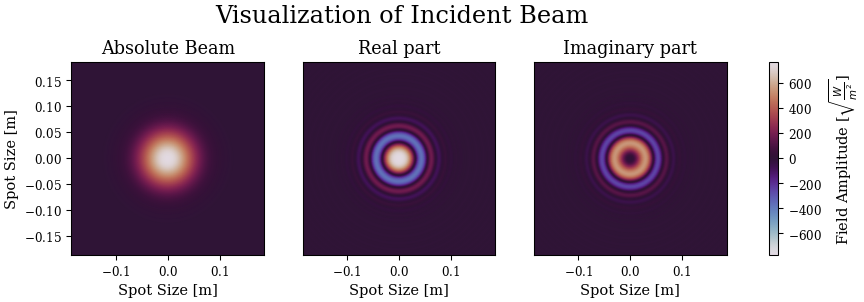

In [6]:
'''
We can plot both the real and imaginary parts of the beam.
'''
vmin = min(np.abs(U_inc).min(), np.real(U_inc).min(), np.imag(U_inc).min())
vmax = max(np.abs(U_inc).max(), np.real(U_inc).max(), np.imag(U_inc).max())

vmin = -np.abs(U_inc).max()
vmax = -vmin

fig, axes = plt.subplots(1,3,figsize=[13,3])
ax0 = axes[0]
ax0.axis('equal')
abso = ax0.pcolormesh(xs_ITM, ys_ITM, np.abs(U_inc), cmap='twilight', vmin=vmin, vmax=vmax)
ax0.set_title('Absolute Beam')
ax0.set_xlabel('Spot Size [m]')
ax0.set_ylabel('Spot Size [m]')
ax1 = axes[1]
ax1.axis('equal')
real = ax1.pcolormesh(xs_ITM, ys_ITM, np.real(U_inc), cmap='twilight', vmin=vmin, vmax=vmax)
ax1.set_title('Real part')
ax1.set_xlabel('Spot Size [m]')
ax1.set_yticks([])
ax2 = axes[2]
ax2.axis('equal')
imag = ax2.pcolormesh(xs_ITM, ys_ITM, np.imag(U_inc), cmap='twilight', vmin=vmin, vmax=vmax)
ax2.set_title('Imaginary part')
ax2.set_xlabel('Spot Size [m]')
ax2.set_yticks([])
cbar = fig.colorbar(abso, ax=[ax0, ax1, ax2], shrink=0.87, anchor=(0,0))
cbar.set_label(r'Field Amplitude [$\sqrt{\frac{W}{m^2}}$]')
plt.suptitle('Visualization of Incident Beam', fontsize=18, x=0.49)
fig.subplots_adjust(top=0.78, right=0.75, left=0.225)
plt.savefig('Media/LCT_incident_beam.jpg')
plt.show()

### Note: As a sanity check, we can check to make sure our units are correct by integrating over the intensity

In [7]:
'''
To calculate the total power of the laser cross-section,
we must calculate the total intensity of the beam and then
integrate over the area by multiplying the total intensity 
by the area element dx * dy.
'''
Intensity_per_unit_area = np.abs(U_inc)**2
total_intensity = np.sum(Intensity_per_unit_area)
total_power = total_intensity * dx_ITM * dy_ITM
print(f'The total power of the laser is {total_power:0.5f} Watts')

The total power of the laser is 2600.00000 Watts


## The mirrors are finite in dimension, so define the mirror aperature maps

In [8]:
'''
First define an array of 1s the same size as our grid
'''
ap_map_ITM = np.ones([M, N], dtype=float)
ap_map_ETM = np.ones([M, N], dtype=float)

'''
Declare that any point on the grid not within
the mirror aperature be set to zero
'''
ap_map_ITM[np.add.outer(ys_ITM**2, xs_ITM**2) > TM_aperture_radius**2] = 0
ap_map_ETM[np.add.outer(ys_ETM**2, xs_ETM**2) > TM_aperture_radius**2] = 0

## Plot the mirror maps to be sure they are correct

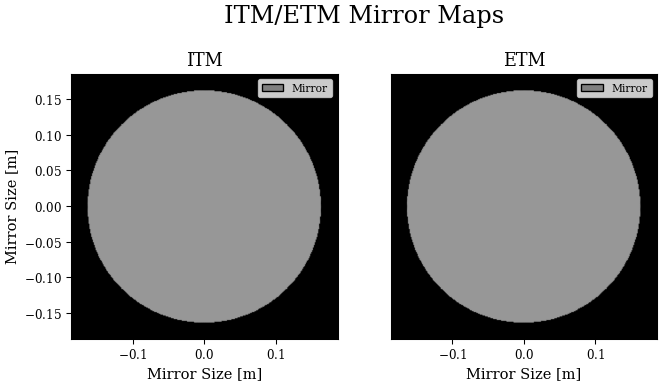

In [9]:
'''
We can plot both the mirror maps.
'''
fig, axes = plt.subplots(1,2,figsize=[10,4])
ax0 = axes[0]
ax0.axis('equal')
ITM = ax0.pcolormesh(xs_ITM,ys_ITM, ap_map_ITM, cmap='Greys_r', vmax=2)
ax0.set_title('ITM')
ax0.set_xlabel('Mirror Size [m]')
ax0.set_ylabel('Mirror Size [m]')
ax1 = axes[1]
ax1.axis('equal')
ETM = ax1.pcolormesh(xs_ETM,ys_ETM, ap_map_ETM, cmap='Greys_r', vmax=2)
ax1.set_title('ETM')
ax1.set_xlabel('Mirror Size [m]')
ax1.set_yticks([])
plt.suptitle('ITM/ETM Mirror Maps', fontsize=18, x=0.445)
legend_elements = [
    Patch(facecolor='Grey', edgecolor='Black', label='Mirror')
]
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), fontsize=8)
axes[1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), fontsize=8)
fig.subplots_adjust(top=0.8, right=0.75, left=0.14)
plt.savefig('Media/LCT_mirror_maps.jpg')
plt.show()

---
# The preemptive work is now complete and we begin defining the LCT operators
---
- This includes both the propagation and curved reflection operators
- We must do this in both the x and y directions
---

In [10]:
'''
First we define the propagation operators in the x and y directions.
These will operate on the input beam, and represent the change the
beam goes through while traveling through the empty space of the cavity.
'''
D_x_ITM_to_ETM = lctf.DLCT(xs_ITM, xs_ETM, M_abcd=md) # ITM -> ETM (x)
D_y_ITM_to_ETM = lctf.DLCT(ys_ITM, ys_ETM, M_abcd=md) # ITM -> ETM (y)
D_x_ETM_to_ITM = lctf.DLCT(xs_ETM, xs_ITM, M_abcd=md) # ETM -> ITM (x)
D_y_ETM_to_ITM = lctf.DLCT(ys_ETM, ys_ITM, M_abcd=md) # ETM -> ITM (y)

'''
Now we define the reflection operators that account for the curved
surface of the mirrors. This is done with a chirp function. They 
will operate on the circulating beam, and represent the change the
beam goes through while reflecting off the mirrors.
'''
C_x_ETM = lctf.CM_kernel(xs_ETM, -2/RoC_ETM, diag=True)
C_y_ETM = lctf.CM_kernel(ys_ETM, -2/RoC_ETM, diag=True)
C_x_ITM = lctf.CM_kernel(xs_ITM, -2/RoC_ITM, diag=True)
C_y_ITM = lctf.CM_kernel(ys_ITM, -2/RoC_ITM, diag=True)

'''
Combine the x and y components of each mirror operator into one.
'''
Rc_map_ETM = np.outer(C_y_ETM, C_x_ETM)
Rc_map_ITM = np.outer(C_y_ITM, C_x_ITM)

## Let's visualize the linear operators

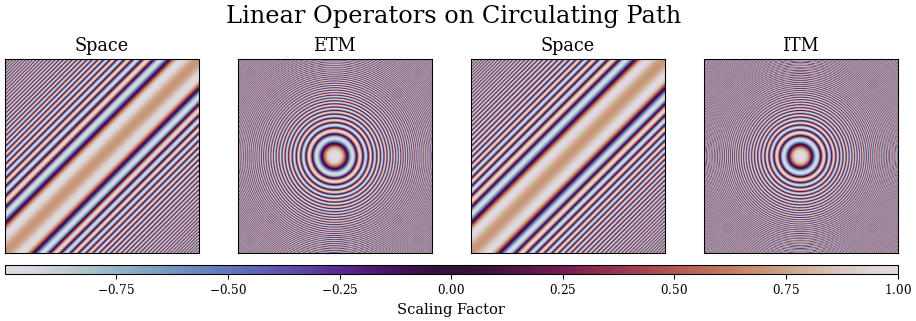

In [14]:
'''
Plot the operators nicely.
'''
fig, axes = plt.subplots(1,4,figsize=(12,3.55))
ax0 = axes[0]
ax0.axis('equal')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Space')
s1 = ax0.pcolormesh(xs_ITM, ys_ITM, np.real(D_x_ITM_to_ETM), cmap='twilight')
ax1 = axes[1]
ax1.axis('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('ETM')
m1 = ax1.pcolormesh(xs_ITM, ys_ITM, np.real(Rc_map_ETM), cmap='twilight')
ax2 = axes[2]
ax2.axis('equal')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Space')
s2 = ax2.pcolormesh(xs_ITM, ys_ITM, np.real(D_x_ETM_to_ITM), cmap='twilight')
ax3 = axes[3]
ax3.axis('equal')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('ITM')
m2 = ax3.pcolormesh(xs_ITM, ys_ITM, np.real(Rc_map_ITM), cmap='twilight')
fig.suptitle('Linear Operators on Circulating Path', fontsize=18, x=0.515)
fig.subplots_adjust(top=0.82)
cbar = fig.colorbar(m1, ax=[ax0, ax1, ax2,ax3], orientation='horizontal', aspect=100, pad=0.05)
cbar.set_label('Scaling Factor')
plt.savefig('Media/LCT_operators_visualization.jpg')
plt.show()

## Now we will define a round-trip operator for the purpose of solving for eigenvalues and eigenvectors such that we can find cavity resonances

In [13]:
'''
This function defines a round-trip operator and then
flattens it to pass to the linear operator constructor.
'''
def op_rt_eig(v):
    Xin = np.reshape(v, [M,N])
    X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
    X2 = ap_map_ETM*Rc_map_ETM*X1
    X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
    X4 = ap_map_ITM*Rc_map_ITM*X3
    return np.ravel(X4)

'''
This scipy function acts as a linear operator constructor.
It takes our predefined operator (in the form of a flattened
1D array), and turns it into an array of shape N*M x N*M.
This will then be used to compute the eigen-stuff of the cavity.
'''
linop_rt_eig = scipy.sparse.linalg.LinearOperator(matvec=op_rt_eig, shape=[N*M,N*M])

## Compute eigenvectors and eigenvalues

In [14]:
'''
Define the number of cavity eigenmodes which we want to solve for.
'''
N_eig = 20

'''
Calculate the eigen values (eh) and vectors (ev)
of the roundtrip linear operator.
'''
eh, ev = scipy.sparse.linalg.eigs(linop_rt_eig, k=N_eig)

In [15]:
'''
This will sort the eigenmodes by there round-trip loss.
idx is their index in the sorted list.
eh_sorted is the list of eigenvalues from least loss to most.
ev_sorted are the cooresponding eigenvectors to eh_sorted.
em_sorted is a combined and sorted array of the two.
'''
idx = np.argsort(np.abs(eh))[::-1]

eh_sorted = eh[idx]
ev_sorted = ev[:,idx]
em_sorted = np.transpose(np.reshape(ev_sorted, [M,N,N_eig]), [2, 0, 1])

## The lowest loss eigenmode should be the HG00 mode. So let's check through them.

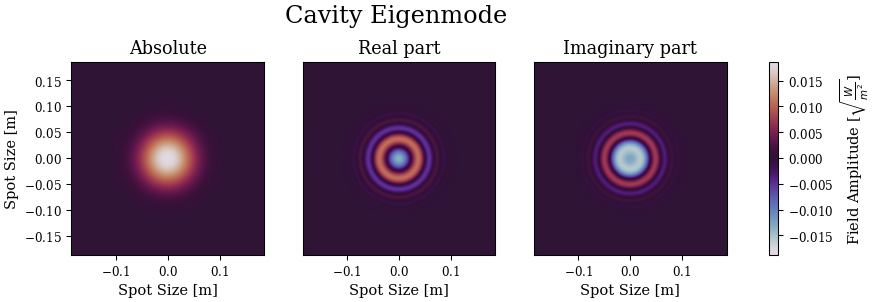

In [16]:
'''
Plot whichever of the eigenmodes you'd like.
If HG00 is not the lowest loss, something fishy may be going on.
Change the eig_idx to look through the list.
'''
eig_idx = 0

vmin = min(np.abs(em_sorted[eig_idx]).min(), np.real(em_sorted[eig_idx]).min(), np.imag(em_sorted[eig_idx]).min())
vmax = max(np.abs(em_sorted[eig_idx]).max(), np.real(em_sorted[eig_idx]).max(), np.imag(em_sorted[eig_idx]).max())

vmin = -np.abs(em_sorted[eig_idx]).max()
vmax = -vmin

fig, axes = plt.subplots(1,3,figsize=[13,3])
ax0 = axes[0]
ax0.axis('equal')
abso = ax0.pcolormesh(xs_ITM, ys_ITM, np.abs(em_sorted[eig_idx]), cmap='twilight', vmin=vmin, vmax=vmax)
ax0.set_title('Absolute')
ax0.set_xlabel('Spot Size [m]')
ax0.set_ylabel('Spot Size [m]')
ax1 = axes[1]
ax1.axis('equal')
real = ax1.pcolormesh(xs_ITM, ys_ITM, np.real(em_sorted[eig_idx]), cmap='twilight', vmin=vmin, vmax=vmax)
ax1.set_title('Real part')
ax1.set_xlabel('Spot Size [m]')
ax1.set_yticks([])
ax2 = axes[2]
ax2.axis('equal')
imag = ax2.pcolormesh(xs_ITM, ys_ITM, np.imag(em_sorted[eig_idx]), cmap='twilight', vmin=vmin, vmax=vmax)
ax2.set_title('Imaginary part')
ax2.set_xlabel('Spot Size [m]')
ax2.set_yticks([])
cbar = fig.colorbar(abso, ax=[ax0, ax1, ax2], shrink=0.87, anchor=(0,0))
cbar.set_label(r'Field Amplitude [$\sqrt{\frac{W}{m^2}}$]')
plt.suptitle('Cavity Eigenmode', fontsize=18, x=0.485)
fig.subplots_adjust(top=0.78, right=0.75, left=0.225)
plt.savefig('Media/LCT_cavity_eigenmode.jpg')
plt.show()

## Compare the HG00 Eigenmode found by the LCT to an Analytical HG00 Eigenmode without mirrors

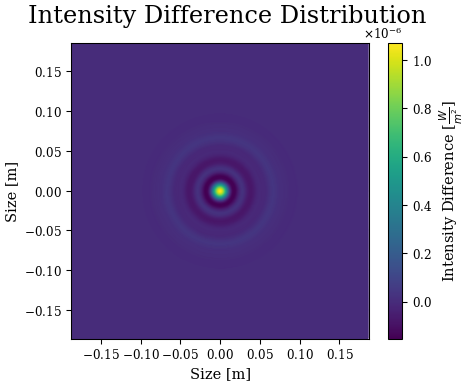

In [17]:
'''
Calculate the analytical HG00 Eigenmode over the cartesian grid,
and normalize it such that the intensity sums to 1.
'''
analytical_HG00 = of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_eig, q_eig, 0, 0)
analytical_HG00 = analytical_HG00*np.sqrt(dx_ITM*dy_ITM)

'''
Plot the difference nicely.
'''
fig, ax = plt.subplots(1,1,figsize=[5,4])
dif = ax.pcolormesh(xs_ITM, ys_ITM, np.abs(em_sorted[0])**2 - np.abs(analytical_HG00)**2)
ax.axis('equal')
ax.set_xlabel('Size [m]')
ax.set_ylabel('Size [m]')
cbar = fig.colorbar(dif)
cbar.set_label(r'Intensity Difference [$\frac{W}{m^2}$]')
plt.suptitle('Intensity Difference Distribution', x=0.45, fontsize=18)
plt.show()

In [18]:
'''
Calculate the loss in intensity of the round trip.
Because we have finite mirrors, there is intensity
escaping past the edges. This effect is minimized
with the HG00 mode which is the lowest lost mode.
'''
rt_loss_numerical = 1 - np.abs(eh_sorted[0])**2
print(f'Round trip intensity loss due purely to mirror apertures is {rt_loss_numerical:.4g} Watts per square meter.' )

Round trip intensity loss due purely to mirror apertures is 1.944e-06 Watts per square meter.


## Compare the analytical round-trip Gouy phase to that of the LCT calculated Gouy Phase

In [19]:
'''
Calculate the analytic gouy phase and the
numerical gouy phase. Take the difference
of the two.
'''
rt_gouy_analytical = np.angle(g_rt, deg=True)
rt_gouy_numerical = np.angle(eh_sorted[0], deg=True)

print(f'Round trip Gouy phase from ABCD matrices is {rt_gouy_analytical} degrees')
print(f'Round trip Gouy phase from LCT eigenvalue is {rt_gouy_numerical} degrees')
print()
print(f'The difference between LCT eigenvalue and analytical round trip Gouy phase \
is {(rt_gouy_analytical - rt_gouy_numerical):.4g} degrees')

Round trip Gouy phase from ABCD matrices is -48.66056335107274 degrees
Round trip Gouy phase from LCT eigenvalue is -48.66058179555486 degrees

The difference between LCT eigenvalue and analytical round trip Gouy phase is 1.844e-05 degrees


## Finally use the eigenmode to ensure cavity is on resonance, then compute the circulating field in the cavity

In [20]:
'''
Normalize the eigenvalue such that we can use it to tune the cavity.
'''
cavity_phase_tuning = np.conj(eh_sorted[0]/np.abs(eh_sorted[0]))

'''
Now we are defining a round-trip operator same as before,
but this time including the cavity phase tuning and the 
reflectivity of the mirrors. This is then reveled to be
fed to the below linear operator constructor.
'''
def op_rt(v):
    Xin = np.reshape(v, [M,N])
    X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
    X2 = ap_map_ETM*Rc_map_ETM*X1*r_ETM
    X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
    X4 = ap_map_ITM*Rc_map_ITM*X3*r_ITM*cavity_phase_tuning
    return np.ravel(X4)

'''
Circulating operator is identity operator minus round trip operator.
'''
def op_circ(v):
    return v - op_rt(v)

'''
This scipy function acts as a linear operator constructor.
It takes our predefined operator (in the form of a flattened
1D array), and turns it into an array of shape N*M x N*M.
'''
linop_rt = scipy.sparse.linalg.LinearOperator(matvec=op_rt, shape=[N*M,N*M])
linop_circ = scipy.sparse.linalg.LinearOperator(matvec=op_circ, shape=[N*M,N*M])

## Now calculate the field at the beginning of the cavity and then the circulating field

In [21]:
'''
This calculates the incident field after propagation through ITM.
'''
U_inc_at_ITM = U_inc * 1j*t_ITM * ap_map_ITM

'''
This neatly turns the input field into a 1D array so that we can 
operate on it with the circulating linear operator.
'''
U_in = np.ravel(U_inc_at_ITM)

'''
This calculates the circulating field as spits it out as a 1D array.
'''
U_circ, _ = scipy.sparse.linalg.gmres(linop_circ, U_in)

'''
This turns our 1D output back into a 2D plot
'''
U_circ = np.reshape(U_circ, [M,N])

## Awesome! Now calculate the powers of the cavity

In [22]:
'''
Calculate powers!
'''
incident_power = np.sum(np.abs(U_inc)**2)*dx_ITM*dy_ITM
circulating_power = np.sum(np.abs(U_circ)**2)*dx_ITM*dy_ITM
planewave_circulating_power = P_in*(t_ITM/(1-r_ETM*r_ITM))**2

print(f'Incident power onto cavity is {incident_power:.5g} W')
print(f'LCT circulating power inside apertured cavity on resonance is {circulating_power:.5g} W')
print(f'Planewave approximation to circulating power on resonance without apertures is {planewave_circulating_power:.5g} W')

Incident power onto cavity is 2600 W
LCT circulating power inside apertured cavity on resonance is 7.3693e+05 W
Planewave approximation to circulating power on resonance without apertures is 7.3713e+05 W


## Now plot the circulating field

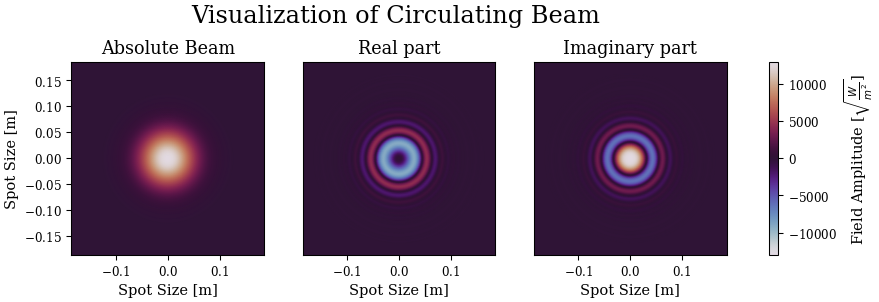

In [23]:
'''
Plot the circulating beam nicely.
'''
vmin = -np.abs(U_circ).max()
vmax = -vmin

fig, axes = plt.subplots(1,3,figsize=[13,3])
ax0 = axes[0]
ax0.axis('equal')
abso = ax0.pcolormesh(xs_ITM, ys_ITM, np.abs(U_circ), cmap='twilight', vmin=vmin, vmax=vmax)
ax0.set_title('Absolute Beam')
ax0.set_xlabel('Spot Size [m]')
ax0.set_ylabel('Spot Size [m]')
ax1 = axes[1]
ax1.axis('equal')
real = ax1.pcolormesh(xs_ITM, ys_ITM, np.real(U_circ), cmap='twilight', vmin=vmin, vmax=vmax)
ax1.set_title('Real part')
ax1.set_xlabel('Spot Size [m]')
ax1.set_yticks([])
ax2 = axes[2]
ax2.axis('equal')
imag = ax2.pcolormesh(xs_ITM, ys_ITM, np.imag(U_circ), cmap='twilight', vmin=vmin, vmax=vmax)
ax2.set_title('Imaginary part')
ax2.set_xlabel('Spot Size [m]')
ax2.set_yticks([])
cbar = fig.colorbar(abso, ax=[ax0, ax1, ax2], shrink=0.87, anchor=(0,0))
cbar.set_label(r'Field Amplitude [$\sqrt{\frac{W}{m^2}}$]')
plt.suptitle('Visualization of Circulating Beam', fontsize=18, x=0.485)
fig.subplots_adjust(top=0.78, right=0.75, left=0.225)
plt.savefig('Media/LCT_circulating_beam.jpg')
plt.show()

## Propagate the circulating field from the ITM to the ETM

In [24]:
'''
Propagate to ETM
'''
U_circ_to_ETM = D_y_ITM_to_ETM@U_circ@D_x_ITM_to_ETM.T

'''
Propagate from ETM
'''
U_circ_from_ETM = ap_map_ETM*U_circ_to_ETM

'''
Compute difference.
This will allow us to estimate the
power lost outside of the mirrors.
'''
U_circ_ETM_to_from_difference = U_circ_to_ETM - U_circ_from_ETM

## Let's plot it

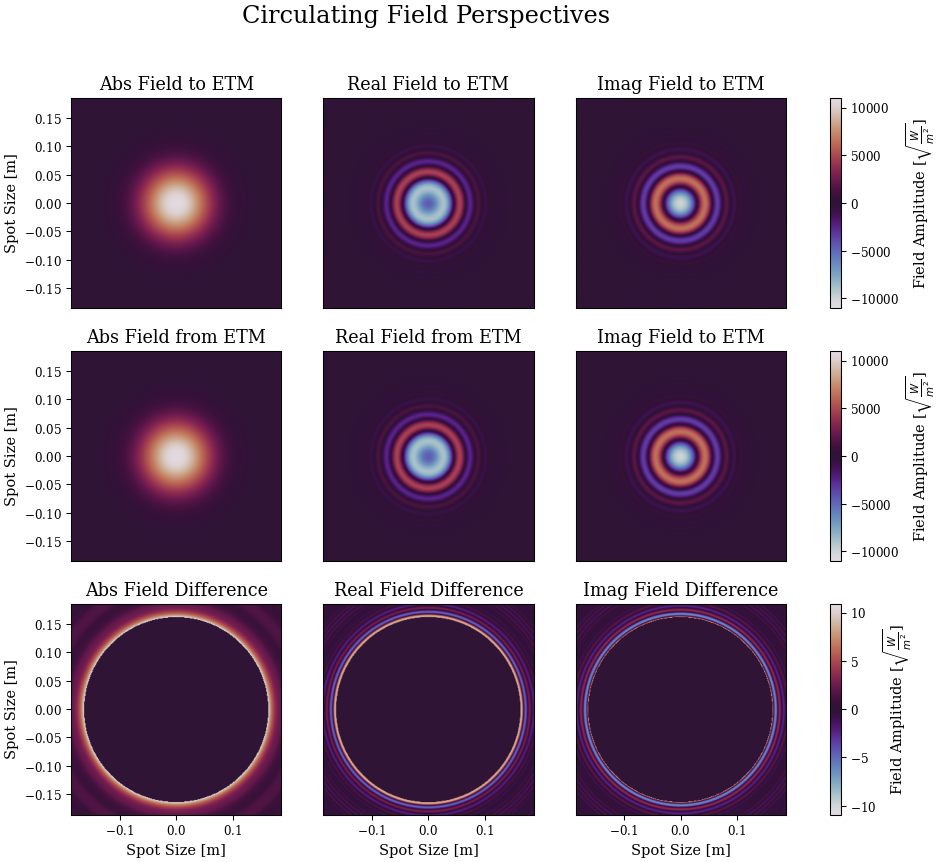

In [25]:
vmin1 = -np.abs(U_circ_to_ETM).max()
vmax1 = -vmin1
vmin2 = -np.abs(U_circ_from_ETM).max()
vmax2 = -vmin2
vmin3 = -np.abs(U_circ_ETM_to_from_difference).max()
vmax3 = -vmin3

fig, axes = plt.subplots(3,3,figsize=[12,9.7])

ax0 = axes[0,0]
ax0.axis('equal')
ax0.set_title('Abs Field to ETM')
ax0.set_xticks([])
ax0.set_ylabel('Spot Size [m]')
abs_to_ETM = ax0.pcolormesh(xs_ETM, ys_ETM, np.abs(U_circ_to_ETM), cmap='twilight', vmin=vmin1, vmax=vmax1)

ax1 = axes[0,1]
ax1.axis('equal')
ax1.set_title('Real Field to ETM')
ax1.set_xticks([])
ax1.set_yticks([])
real_to_ETM = ax1.pcolormesh(xs_ETM, ys_ETM, np.real(U_circ_to_ETM), cmap='twilight', vmin=vmin1, vmax=vmax1)

ax2 = axes[0,2]
ax2.axis('equal')
ax2.set_title('Imag Field to ETM')
ax2.set_xticks([])
ax2.set_yticks([])
imag_to_ETM = ax2.pcolormesh(xs_ETM, ys_ETM, np.imag(U_circ_to_ETM), cmap='twilight', vmin=vmin1, vmax=vmax1)
cbar1 = fig.colorbar(abs_to_ETM, ax=[ax0,ax1,ax2])
cbar1.set_label(r'Field Amplitude [$\sqrt{\frac{W}{m^2}}$]')

ax3 = axes[1,0]
ax3.axis('equal')
ax3.set_title('Abs Field from ETM')
ax3.set_xticks([])
ax3.set_ylabel('Spot Size [m]')
abs_from_ETM = ax3.pcolormesh(xs_ETM, ys_ETM, np.abs(U_circ_from_ETM), cmap='twilight', vmin=vmin2, vmax=vmax2)

ax4 = axes[1,1]
ax4.axis('equal')
ax4.set_title('Real Field from ETM')
ax4.set_xticks([])
ax4.set_yticks([])
real_from_ETM = ax4.pcolormesh(xs_ETM, ys_ETM, np.real(U_circ_from_ETM), cmap='twilight', vmin=vmin2, vmax=vmax2)

ax5 = axes[1,2]
ax5.axis('equal')
ax5.set_title('Imag Field to ETM')
ax5.set_xticks([])
ax5.set_yticks([])
imag_from_ETM = ax5.pcolormesh(xs_ETM, ys_ETM, np.imag(U_circ_from_ETM), cmap='twilight', vmin=vmin2, vmax=vmax2)
cbar2 = fig.colorbar(abs_from_ETM, ax=[ax3,ax4,ax5])
cbar2.set_label(r'Field Amplitude [$\sqrt{\frac{W}{m^2}}$]')

ax6 = axes[2,0]
ax6.axis('equal')
ax6.set_title('Abs Field Difference')
ax6.set_xlabel('Spot Size [m]')
ax6.set_ylabel('Spot Size [m]')
abs_Diff = ax6.pcolormesh(xs_ETM, ys_ETM, np.abs(U_circ_ETM_to_from_difference), cmap='twilight', vmin=vmin3, vmax=vmax3)

ax7 = axes[2,1]
ax7.axis('equal')
ax7.set_title('Real Field Difference')
ax7.set_xlabel('Spot Size [m]')
ax7.set_yticks([])
real_Diff = ax7.pcolormesh(xs_ETM, ys_ETM, np.real(U_circ_ETM_to_from_difference), cmap='twilight', vmin=vmin3, vmax=vmax3)

ax8 = axes[2,2]
ax8.axis('equal')
ax8.set_title('Imag Field Difference')
ax8.set_xlabel('Spot Size [m]')
ax8.set_yticks([])
imag_Diff = ax8.pcolormesh(xs_ETM, ys_ETM, np.imag(U_circ_ETM_to_from_difference), cmap='twilight', vmin=vmin3, vmax=vmax3)
cbar3 = fig.colorbar(abs_Diff, ax=[ax6,ax7,ax8])
cbar3.set_label(r'Field Amplitude [$\sqrt{\frac{W}{m^2}}$]')

plt.suptitle('Circulating Field Perspectives', fontsize=18, x=0.4325)
plt.savefig('Media/LCT_circulating_perspectives.jpg')
plt.show()

## We can see some very weak diffraction rings that aren't being reflected by the ETM! Our cavity loses a bit of power because of this, specifically the loss calculated from the eigenmode times the circulating power!

In [26]:
'''
Calculate the power lost from the eigenmode solution.
'''
power_loss_eig = rt_loss_numerical*circulating_power

'''
Estimate the power lost from the diffraction rings themselves.
NOTE: This is only an estimate because the full extent of the
diffraction rings aren't captured in the plot!
'''
power_loss_rings = np.sum(np.abs(U_circ_ETM_to_from_difference)**2) * dx_ETM * dy_ETM

print(f'The TRUE/numerical power loss is {power_loss_eig:0.5f} Watts')
print(f'The estimated power loss from plotted rings is {power_loss_rings:0.5f} Watts')

The TRUE/numerical power loss is 1.43233 Watts
The estimated power loss from plotted rings is 0.78477 Watts


---
# Now let's perform a cavity scan to examine some resonances

In [27]:
'''
Define the number resolution of our scan,
the extent of our scan, and the output array.
NOTE: By "extent of our scan" is meant how much
will the placement of the ETM change. Are are not
simply adding a flat length to the round trip distance.
'''
Nphi = 301
phis_plot = np.linspace(-20, 380, Nphi)
out = np.zeros([Nphi, M, N], dtype=np.complex128)

'''
The following will do the exact same things as was done early,
but it will do so in an iterative fashion over the range of 
phis we have defined. It also has a fancy percentage completion.
'''
for k, phi in enumerate(phis_plot):
    print(f'Cavity Scan {(k+1)/Nphi*100 :0.2f}% Complete', end=' '*90+'\r')
    g = np.exp(-2j*phi/180*np.pi)
    
    # normalize the eigenvalue to use it for putting the cavity on resonance
    cavity_phase_tuning = np.conj(g_rt)

    def op_rt(v):
        '''Round trip operator. Put in mirror reflectivities and put the cavity on resonance.
        '''
        Xin = np.reshape(v, [M,N])
        X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
        X2 = ap_map_ETM*Rc_map_ETM*X1*r_ETM
        X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
        X4 = ap_map_ITM*Rc_map_ITM*X3*r_ITM*cavity_phase_tuning*g
        return np.ravel(X4)

    def op_circ(v):
        '''Circulating operator is identity operator minus round trip operator.
        '''
        return v - op_rt(v)

    linop_circ = scipy.sparse.linalg.LinearOperator(matvec=op_circ, shape=[N*M,N*M])
    U_circ, _ = scipy.sparse.linalg.gmres(linop_circ, np.ravel(U_in))
    
    out[k,:,:] = np.reshape(U_circ, [M,N])

## With the iterative calculation of the field complete, we calculate the power at each phi step and plot it!

In [28]:
'''
This calculates the power of the beam at each phi step,
and puts it in a neat array for the purpose of plotting.
'''
cavity_scan = np.sum(np.sum(np.abs(out)**2, axis=1), axis=1)*dy_ITM*dx_ITM

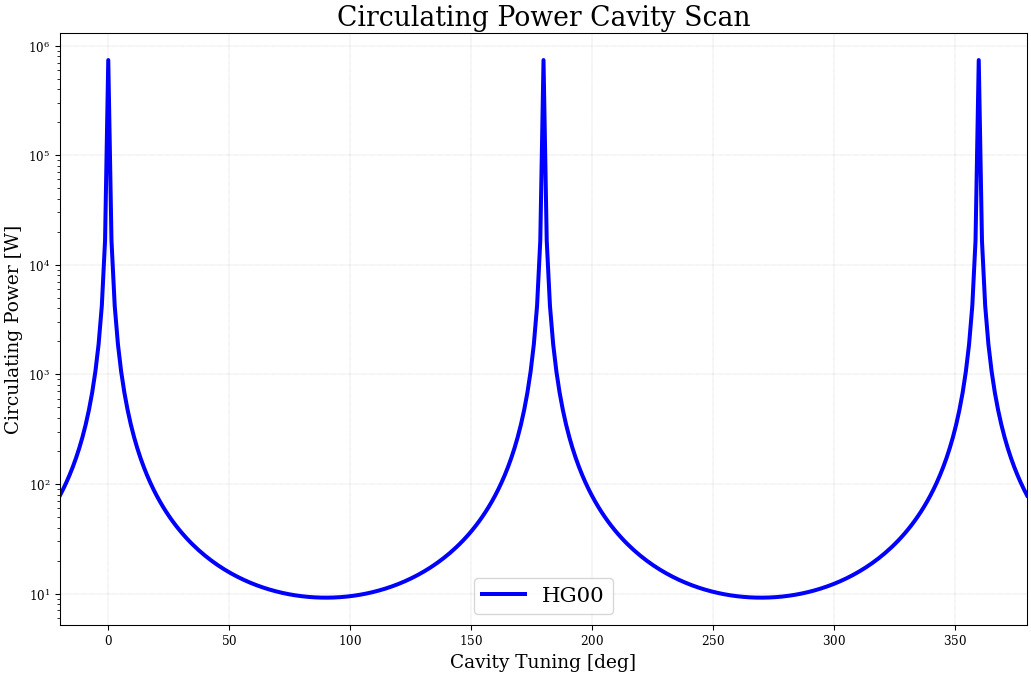

In [29]:
'''
Plot the cavity scan nicely.
'''
fig, ax = plt.subplots(1, 1, figsize=[13,8])
ax = ax
cav_scan = ax.semilogy(phis_plot, cavity_scan, linewidth=3, label='HG00')
ax.set_xlabel('Cavity Tuning [deg]', fontsize=14)
ax.set_ylabel('Circulating Power [W]', fontsize=14)
ax.set_title('Circulating Power Cavity Scan', fontsize=20)
ax.legend(loc='lower center', fontsize=16)
plt.show()

## Congrats! You now understand the basics of the LCT.